# Why do TV series get cancelled?

The kind folks at [IMDb](https://www.imdb.com/interfaces/) (owned by Amazon) provide an up-to-date dataset of their extensive movie database for personal and non-commercial use.

We've always wondered by TV series that have a die-hard following get cancelled. We figured we could visualize our way to some answers.

We'd like to show you what we found (or didn't?).

Let's import the modules we depend on:

In [38]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Genres

Let's see what genres can ~~tell~~ show us!

Load the TSV file containing information about titles:

In [39]:
ratings_dtype = {
    'tconst': str,
    'averageRating': float,
    'numVotes': int
}

ratings = pd.read_csv('./title.ratings.tsv.gz',
                      sep='\t', header=0, dtype=ratings_dtype)

In [40]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.8,1383
1,tt0000002,6.5,162
2,tt0000003,6.6,971
3,tt0000004,6.4,98
4,tt0000005,6.2,1663


Load TSV file containing IMDb rating and votes information for titles:

In [41]:
title_dtype = {
    'tconst': str,
    'titleType': str,
    'primaryTitle': str,
    'originalTitle': str,
    'isAdult': int,
    'startYear': str,
    'endYear': str,
    'runtimeMinutes': object,
    'genres': str
}

title = pd.read_csv('./title.basics.tsv.gz',
                    sep='\t', header=0, dtype=title_dtype)

In [42]:
title.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


What are the types of titles?

In [43]:
title['titleType'].unique()

array(['short', 'movie', 'tvMovie', 'tvSeries', 'tvEpisode', 'tvShort',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

Create a data frame containing only TV series:

In [44]:
series = title[title['titleType'] == 'tvSeries']
series.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,\N
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,\N
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"Family,Game-Show"
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,Family
38462,tt0039122,tvSeries,The Borden Show,The Borden Show,0,1947,\N,30,"Comedy,Music"


What are the genres a TV series could belong to?

In [45]:
genres_with_dupes = series['genres'].map(lambda x: [] if x == '\\N' else x.split(','))
genres_with_dupes_list = [y for x in genres_with_dupes for y in x]
genres = list(set(genres_with_dupes_list))
genres

['Music',
 'Drama',
 'Western',
 'Animation',
 'Musical',
 'Fantasy',
 'Reality-TV',
 'Talk-Show',
 'Romance',
 'Thriller',
 'Adventure',
 'Comedy',
 'Documentary',
 'Adult',
 'Short',
 'Game-Show',
 'Mystery',
 'Horror',
 'Biography',
 'Action',
 'Crime',
 'Sport',
 'Sci-Fi',
 'History',
 'News',
 'Family',
 'War']

Set genres column in series dataframe to array of genres:

In [46]:
# To get rid of SettingWithCopyWarning. See https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
series.is_copy = False

series['genres'] = genres_with_dupes
series.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,[]
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,[]
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"[Family, Game-Show]"
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,[Family]
38462,tt0039122,tvSeries,The Borden Show,The Borden Show,0,1947,\N,30,"[Comedy, Music]"


### How many TV series have ever been released in each genres?

In [47]:
genre_ratios = pd.Series(genres_with_dupes_list).value_counts()
top_10_genres = genre_ratios[:10].index.values
# Flip values
# genre_ratios = pd.Series(genre_ratios.index.values, index=genre_ratios)

# Pair each genre among the top 10 with a color.
hexs = ["#96ceb4", "#ffcc5c", "#f9d5e5", "#d9ad7c", "#87bdd8",
          "#937860", "#7a3b2e", "#c1502e", "#ff6f69", "#ffeead"]

colors = {}
for g, c in zip(top_10_genres, hexs):
  colors[g] = c

genre_ratios.head()

Comedy         36302
Drama          23299
Documentary    16715
Reality-TV     13859
Talk-Show      11077
dtype: int64

In [48]:
def plot_count_per_genre():
    sns.set_style("whitegrid", {'axes.grid' : False})
    d = pd.DataFrame(data={'genre': genres_with_dupes_list})
    ax = sns.countplot(y='genre', data=d, palette='Set2', order=d['genre'].value_counts().index)
    plt.title('Total numbers of series produced across all genres')

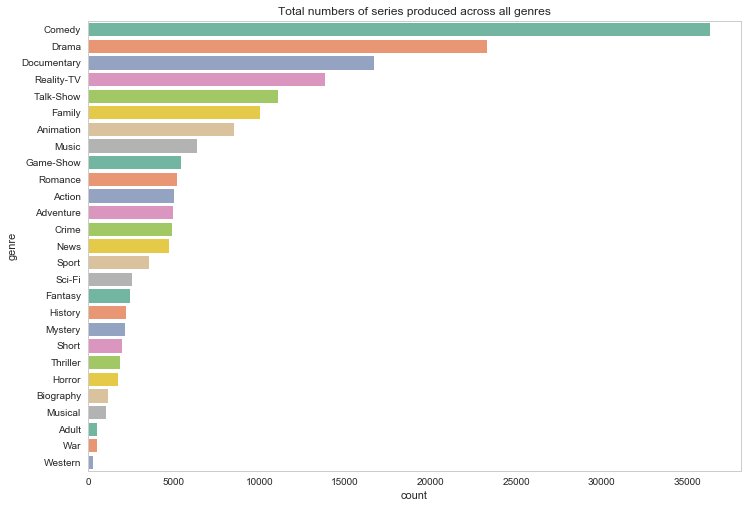

In [49]:
plot_count_per_genre()

### How have the numbers of series produced in each genre changed over the years?

What range of years do we have data for?

In [50]:
start_years = [i for i in title['startYear'].unique() if i != '\\N']
n = list(map(int, start_years))
min(n), max(n)

(1874, 2115)

We want the numbers of TV series released within each genre every year.

In [51]:
def count_genres(year):
  matches = series.loc[series['startYear'] == year]
  gs = [y for x in matches['genres'] for y in x if y != '\\N']
  return {x: gs.count(x) for x in gs}

genres_by_year = []
for yr in start_years:
  gc = count_genres(yr)
  if bool(gc): genres_by_year.append((yr,gc))
        
genres_by_year[1:5]

[('1910', {'News': 1}),
 ('1916', {'Talk-Show': 1}),
 ('1936', {'Comedy': 3, 'Family': 1, 'Music': 3, 'Sport': 1, 'Talk-Show': 1}),
 ('1922', {'News': 1})]

In [52]:
sns.set_style("whitegrid", {'axes.grid' : False})

def create_genre_df(genre):
  gs = []
  for j in genres_by_year:
    if genre in j[1] and int(j[0]) > 1980 and int(j[0]) < 2018:
      gs.append((j[0], j[1][genre]))

  sorted(gs, key=lambda x: int(x[0]))

  xs, ys = zip(*gs)

  df = pd.DataFrame({'Years': pd.Series(xs), genre: pd.Series(ys)})
  df['Years'] = pd.to_datetime(df['Years'])
  df = df.sort_values(by='Years')

  return df

def plot_num_of_series():
    dfs = [(genre, create_genre_df(genre)) for genre in top_10_genres]

    fig = plt.figure()

    for genre, frame in dfs:
        plt.plot(frame['Years'], frame[genre], color = colors[genre])

    plt.legend()
    plt.title('Numbers of series produced over the years for the top 10 genres')
    plt.show()

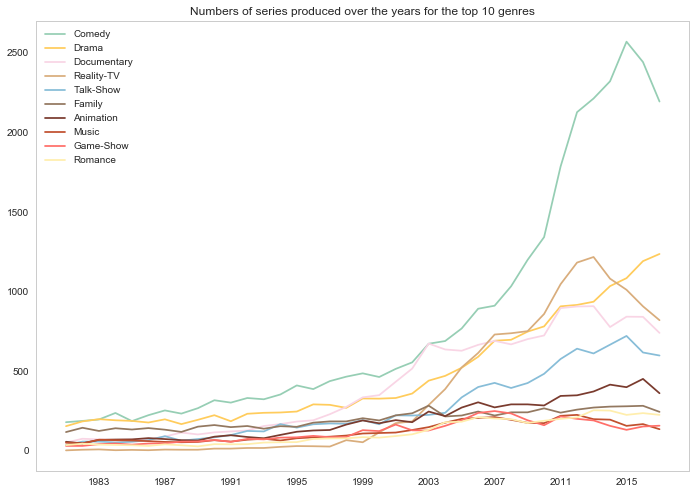

In [53]:
plot_num_of_series()

### What are the percentages of TV Genres over the years?

Create data frame of genres in long form:

In [54]:
df1 = series[['startYear', 'genres']].dropna(subset=['startYear'])
df1 = df1[df1['startYear'] != '\\N']
pd.to_numeric(df1['startYear'])
df1 = pd.DataFrame(df1['genres'].tolist(), index=df1['startYear']).stack().reset_index(name='genres')[['genres','startYear']]
df1.tail()

,genres,startYear
174041,Talk-Show,2018
174042,Documentary,2018
174043,Sci-Fi,2019
174044,Adult,2005
174045,Crime,2018


In [55]:
def plot_genres_percents(df):
    sns.set_style('whitegrid', {'axes.grid' : False})
    df['startYear'] = pd.to_numeric(df['startYear'])
    df = df[df['startYear'] > 1989]
    df = df[df['startYear'] < 2018]
    df = df[df['genres'].isin(top_10_genres)]

    props = lambda key: {'color': colors[key[1]]}
    ax, _ = mosaic(df.sort_values('startYear'), ['startYear', 'genres'], label_rotation=(90,0),
                   labelizer=(lambda _: ''), properties=props, title='Percentages of series made in each genre')

    plt.show()

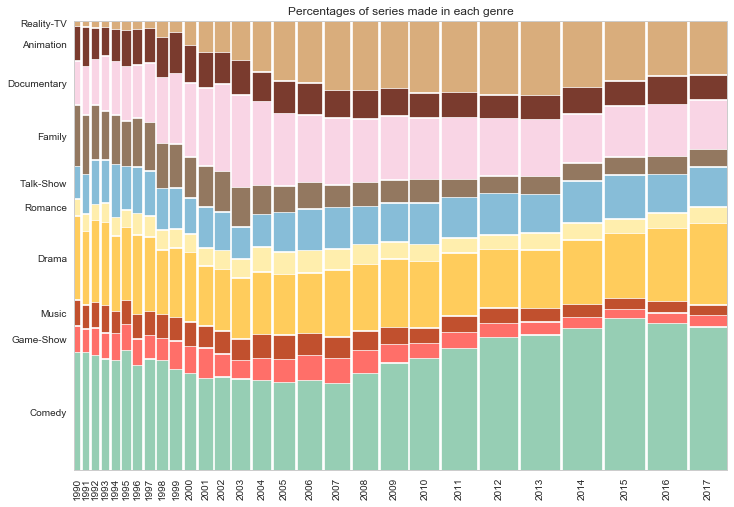

In [56]:
plot_genres_percents(df1)

## Running Years of TV Series

Figure out the series that we know ran to completion and their durations:

In [57]:
df = series[series['startYear'] != '\\N']
df = df[df['endYear'] != '\\N']
df = df.dropna(subset=['startYear', 'endYear', 'primaryTitle'], how='any')
df['runningYears'] = pd.to_numeric(df['endYear']) - pd.to_numeric(df['startYear'])
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,runningYears
34995,tt0035599,tvSeries,Voice of Firestone Televues,Voice of Firestone Televues,0,1943,1947,15,[],4
37626,tt0038276,tvSeries,You Are an Artist,You Are an Artist,0,1946,1950,15,[],4
38460,tt0039120,tvSeries,Americana,Americana,0,1947,1949,30,"[Family, Game-Show]",2
38461,tt0039121,tvSeries,Birthday Party,Birthday Party,0,1947,1949,30,[Family],2
38463,tt0039123,tvSeries,Kraft Theatre,Kraft Television Theatre,0,1947,1958,60,[Drama],11


### What are the average running years for genres?

In [58]:
sns.set_style('darkgrid', {'axes.grid' : True})

def plot_genre_average(df, col_to_avg, x_label, y_label, title):
  vals_to_avg = []

  for g in genres:
    f = df[df.genres.apply(lambda x: g in x)]
    vals_to_avg.append((g, f[col_to_avg].mean()))

    xs, ys = zip(*vals_to_avg)

  d = pd.DataFrame(data={y_label: xs, x_label: ys})
  d = d.sort_values(by=[x_label], ascending=False)

  ax = sns.barplot(y=y_label, x=x_label, data=d)
  ax.set(xlim=(0, 10))
  ax.set_title(title)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

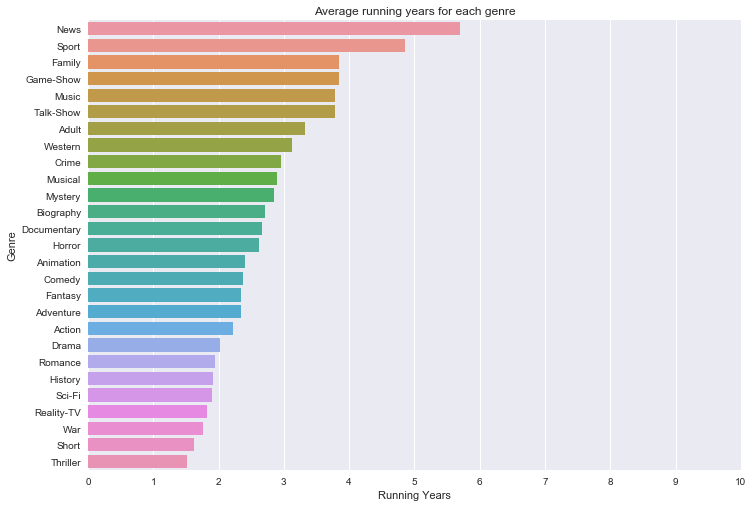

In [59]:
plot_genre_average(df, 'runningYears', 'Running Years', 'Genre', 'Average running years for each genre')

### What are the average ratings for genres?
First, let's add ratings information to TV series:

In [60]:
series_with_ratings = pd.merge(series, ratings, how='outer', on=['tconst'])
# Drop rows that do not have a genre or rating
series_with_ratings = series_with_ratings.dropna(subset=['genres', 'averageRating'], how='any')
series_with_ratings.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
2,tt0039120,tvSeries,Americana,Americana,0.0,1947,1949,30,"[Family, Game-Show]",3.7,6.0
5,tt0039123,tvSeries,Kraft Theatre,Kraft Television Theatre,0.0,1947,1958,60,[Drama],8.5,108.0
7,tt0039125,tvSeries,Public Prosecutor,Public Prosecutor,0.0,1947,1951,20,"[Crime, Drama, Mystery]",5.9,7.0
8,tt0040021,tvSeries,Actor's Studio,Actor's Studio,0.0,1948,1950,30,[Drama],7.1,48.0
15,tt0040028,tvSeries,Talent Scouts,Talent Scouts,0.0,1948,1958,30,"[Comedy, Family, Music]",6.1,11.0


### Average Genre Ratings

Calculate average ratings for each genre:

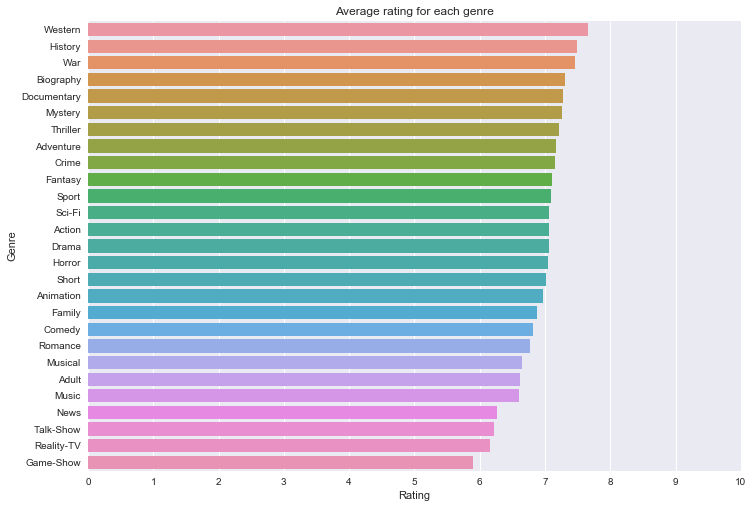

In [61]:
plot_genre_average(series_with_ratings, 'averageRating', 'Rating', 'Genre', 'Average rating for each genre')

### What does the distribution of running years for the top 10 genres look like?

Let's create a table containing running years for each genres appearance across all TV series (long form for the `genres` column).

In [62]:
df2 = df[['runningYears', 'genres']].dropna(subset=['runningYears'])
pd.to_numeric(df2['runningYears'])
df2 = pd.DataFrame(df2['genres'].tolist(), index=df2['runningYears']).stack().reset_index(name='genres')[['genres','runningYears']]
df2 = df2[df2['genres'].isin(top_10_genres)]
df2.head()

,genres,runningYears
0,Family,2
1,Game-Show,2
2,Family,2
3,Drama,11
5,Drama,4


In [63]:
def plot_duration_dist(df):
    sns.set_style('whitegrid', {'axes.grid' : True})
    _ = sns.violinplot(x='genres', y='runningYears',
                       data=df).set_title('Distribution of running years for  the top 10 genres')

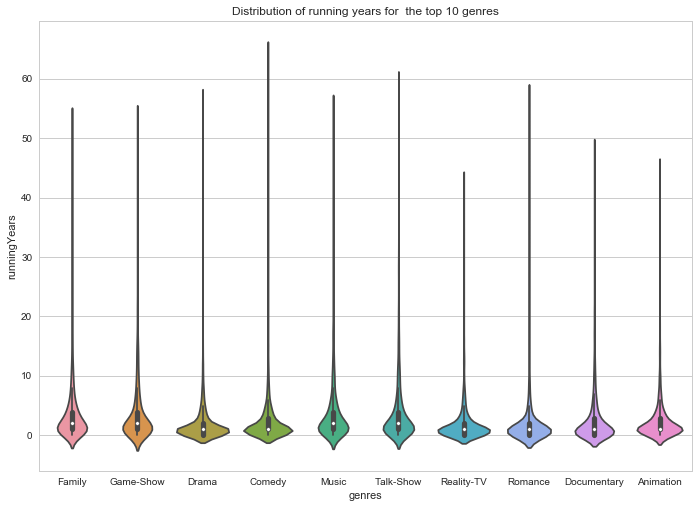

In [64]:
plot_duration_dist(df2)

Let's remove outliers for running years so that our distribution is not heavily skewed. The summary statistics below tells us that the 75% percentile of TV series last 3 years or less. Common knowledge tells us that most TV series don't last for more than 10 seasons, so we can cap the running years at 10 years.

count    35720.000000
mean         2.730795
std          4.444384
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         65.000000
Name: runningYears, dtype: float64

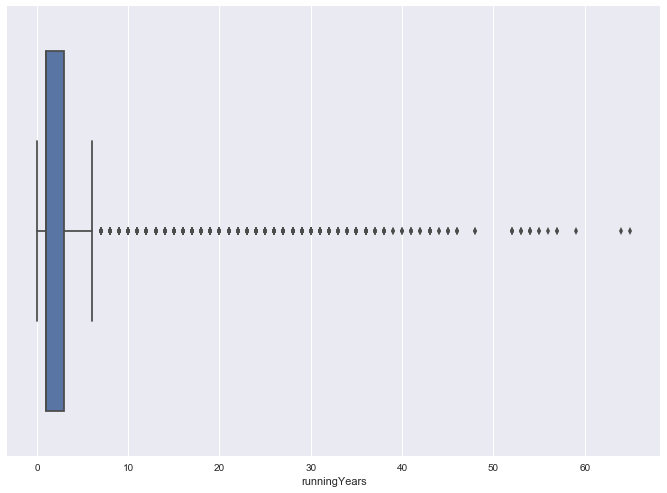

In [65]:
sns.set_style('darkgrid', {'axes.grid' : True})
sns.boxplot(x=df2['runningYears']); df2['runningYears'].describe()

In [66]:
df3 = df2.copy()
df3.loc[df3['runningYears'] > 10,'runningYears'] = 10

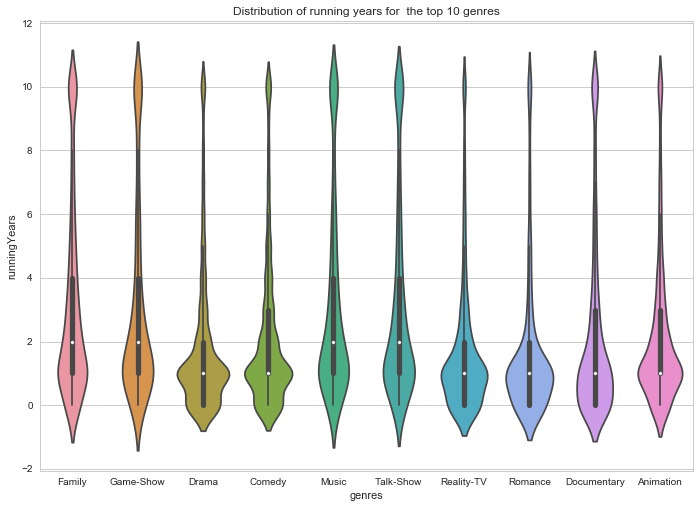

In [67]:
plot_duration_dist(df3)

The violin plot above shows evidence of different distributions of running years for the TV series genres. Let's further explore those differences where the distributions are more dense, which appears to be from 0 to 5 years.

In [68]:
df4 = df2.copy()
df4.loc[df4['runningYears'] > 5,'runningYears'] = 5

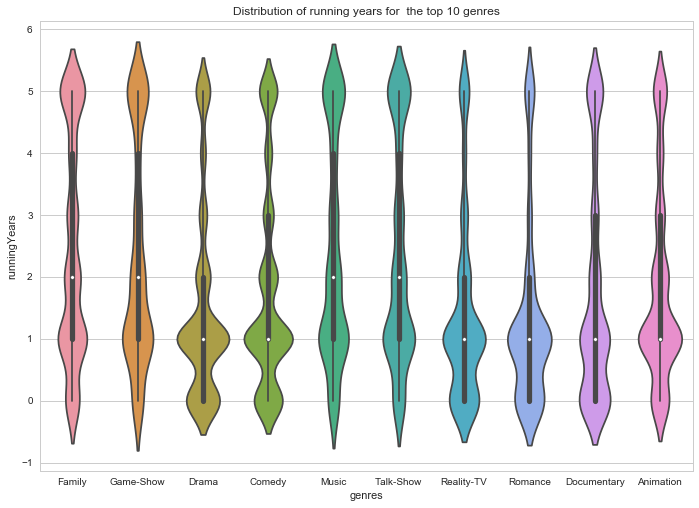

In [69]:
plot_duration_dist(df4)

### What does the distribution of average ratings for the top 10 genres look like?

In [70]:
df5 = series_with_ratings[['averageRating', 'genres']].dropna(subset=['averageRating'])
pd.to_numeric(df5['averageRating'])
df5 = pd.DataFrame(df5['genres'].tolist(), index=df5['averageRating']).stack().reset_index(name='genres')[['genres','averageRating']]
df5 = df5[df5['genres'].isin(top_10_genres)]
df5.head()

,genres,averageRating
0,Family,3.7
1,Game-Show,3.7
2,Drama,8.5
4,Drama,5.9
6,Drama,7.1


In [71]:
def plot_rating_dist(df):
    sns.set_style('whitegrid', {'axes.grid' : True})
    _ = sns.violinplot(x='genres', y='averageRating',
                       data=df).set_title('Distribution of average ratings for  the top 10 genres')

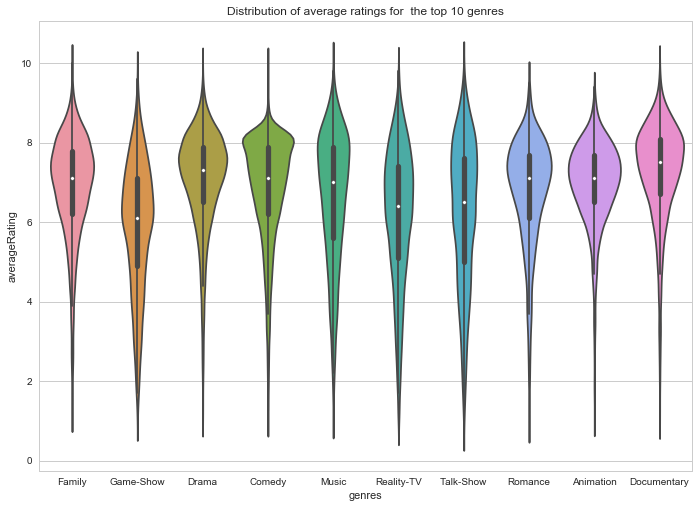

In [72]:
plot_rating_dist(df5)

Let's zoom in to the range where average ratings differ the most, which is from `3` to `9`.

In [73]:
df6 = df5.copy()
df6.loc[df6['averageRating'] < 3,'averageRating'] = 3
df6.loc[df6['averageRating'] > 9,'averageRating'] = 9

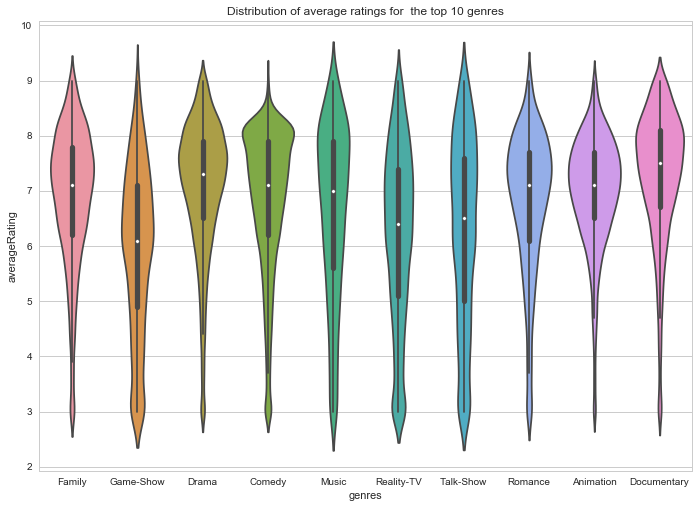

In [74]:
plot_rating_dist(df6)